# Background

## Goal

To predict when employees are going to quit by understanding the main drivers of employee churn.

## Tasks

Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id.


What are the main factors that drive employee churn? Do they make sense? Explain your findings.


If you could add to this data set just one variable that could help explain employee churn, what would that be?

## Dataset

employee_id : id of the employee. Unique by employee per company company_id : company id.

dept : employee dept

seniority : number of yrs of work experience when hired

salary: avg yearly salary of the employee during her tenure within the company join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13

quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)

In [1]:
import sys
!{sys.executable} -m pip install pdpbox

     |████████████████████████████████| 57.7MB 88.1MB/s eta 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [128]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
# from numpy.linalg import inv
# import pdpbox
# from pdpbox import pdp
# from pdpbox.info_plots import target_plot

from statsmodels.multivariate.manova import MANOVA
from datetime import date, timedelta

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.tree.export import export_text

In [99]:
dt = pd.read_csv('employee_retention_data.csv',parse_dates=['join_date','quit_date'])

In [35]:
dt.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


## Headcount Estimate

In [7]:
now_date = date(2011, 1, 24)
end_date = date(2015, 12, 31)

In [8]:
sub_cnt = dt[dt['join_date']<=now_date]
cnt_company = pd.DataFrame(sub_cnt.groupby('company_id')['company_id'].count())
sub_quit = sub_cnt[(sub_cnt['quit_date'].isna())|(sub_cnt['quit_date']>now_date)]
quit_company = pd.DataFrame(sub_quit.groupby('company_id')['company_id'].count())
hc = cnt_company-quit_company
hc.columns=['employee_headcount']
hc['company_id']=hc.index
hc['date'] = now_date

In [9]:
delta = timedelta(days=1)
while now_date <= end_date:
    now_date += delta
    sub_cnt = dt[dt['join_date']<=now_date]
    cnt_company = pd.DataFrame(sub_cnt.groupby('company_id')['company_id'].count())
    sub_quit = sub_cnt[(sub_cnt['quit_date'].isna())|(sub_cnt['quit_date']>now_date)]
    quit_company = pd.DataFrame(sub_quit.groupby('company_id')['company_id'].count())
    hc1 = cnt_company-quit_company
    hc1.columns=['employee_headcount']
    hc1['company_id']=hc1.index
    hc1['date'] = now_date
    hc = pd.concat([hc,hc1])

In [10]:
hc.shape

(21563, 3)

## Variable Check

To find out the useful variable, I would build a decision tree and check the nodes. Before building the model, I would create one more column in case of the cohort effect.
Also, I will check whether the variables are independent after creating the new working_time variable.

### Create Cohort Effect Variable

### Check the multual independence between variables

Need to read the book first....

## Decision Tree

In [100]:
dt['quit_or_not'] = dt['quit_date'].isna()

In [101]:
dt1 = dt.fillna( max(dt['quit_date'])+ pd.to_timedelta(23, unit='d'))

In [102]:
dt1['wrk_time'] = dt1['quit_date']-dt1['join_date']

In [103]:
dt1.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_or_not,wrk_time
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,False,585 days
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,False,340 days
2,927315.0,4,marketing,14,101000.0,2014-10-13,2016-01-01,True,445 days
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,False,389 days
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,False,1040 days


In [104]:
dt1 = pd.get_dummies(dt1, prefix_sep="__",columns=['dept'])


In [105]:
dt1['join_date_int'] = dt1['join_date'].astype(int)/ 10**15
#dt1['quit_date_int'] = dt1['quit_date'].astype(int)/ 10**15
dt1['wrk_time_int'] = dt1['wrk_time'].dt.days

In [106]:
dt1.shape

(24702, 16)

In [107]:
a = list(range(4))+list(range(8,16))
X = dt1.iloc[:,a]
Y = dt1.iloc[:,6]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1) 

In [108]:
clf_gini = DecisionTreeClassifier(criterion = "gini", 
            random_state = 1,max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [112]:
y_pred = clf_gini.predict(X_test) 
confusion_matrix(y_test, y_pred)

array([[3704,  392],
       [ 273, 3042]])

In [113]:
accuracy_score(y_test,y_pred)*100

91.02685197679125

In [114]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n       False       0.93      0.90      0.92      4096\n        True       0.89      0.92      0.90      3315\n\n    accuracy                           0.91      7411\n   macro avg       0.91      0.91      0.91      7411\nweighted avg       0.91      0.91      0.91      7411\n'

In [116]:
sum(dt['quit_or_not'])/dt.shape[0]

0.453080722208728

In [120]:
clf_gini.feature_importances_

array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.6639034, 0.3360966])

In [127]:
export_text(clf_gini, feature_names=)

Object `feature_importances_` not found.


[Text(141.64615384615385, 190.26, 'X[10] <= 1387.195\nentropy = 0.496\nsamples = 17291\nvalue = [9414, 7877]'),
 Text(51.50769230769231, 135.9, 'X[11] <= 745.5\nentropy = 0.342\nsamples = 10318\nvalue = [8062, 2256]'),
 Text(25.753846153846155, 81.53999999999999, 'entropy = 0.0\nsamples = 5301\nvalue = [5301, 0]'),
 Text(77.26153846153846, 81.53999999999999, 'X[10] <= 1346.069\nentropy = 0.495\nsamples = 5017\nvalue = [2761, 2256]'),
 Text(51.50769230769231, 27.180000000000007, 'entropy = 0.335\nsamples = 2714\nvalue = [2137, 577]'),
 Text(103.01538461538462, 27.180000000000007, 'entropy = 0.395\nsamples = 2303\nvalue = [624, 1679]'),
 Text(231.7846153846154, 135.9, 'X[10] <= 1418.04\nentropy = 0.313\nsamples = 6973\nvalue = [1352, 5621]'),
 Text(180.27692307692308, 81.53999999999999, 'X[11] <= 395.5\nentropy = 0.471\nsamples = 3393\nvalue = [1291, 2102]'),
 Text(154.52307692307693, 27.180000000000007, 'entropy = 0.078\nsamples = 1027\nvalue = [985, 42]'),
 Text(206.03076923076924, 27.

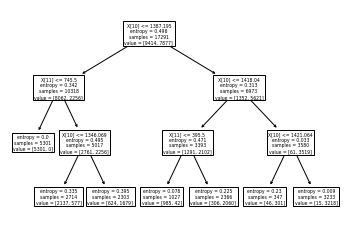

In [124]:
tree.plot_tree(clf_gini) 

# Note

## Common Model
Decision Trees (rpart)
Boosted Models (adaboost)
Random Forests (rf)
Support Vactor Models (svm)
Linear Models (glm)

## Common Goal


## Good Practices
1. Predicting and preventing turnover at HP
 By using predictive models, they generated what they called a “Flight Risk” score. This score predicted the likelihood of leaving of each of HP’s 300,000 plus employees. Based on the data, they could see why employees would leave HP. Higher pay, promotions, and better performance ratings where, for instance, negatively related to flight risk. The system exerts pressure on managers to develop strategies to retain their staff. This helps to reduce costs and maintain business continuity.
 
2. Predicting hire success at Google
The questions interviewees get asked in Google’s hiring process are all fully automated, computer-generated, and fine-tuned in order to find the best candidate. There are a lot of other relevant metrics in recruiting that you should keep track of to see whether you’re hiring the right people. These include advanced metrics like time to productivity and cost of getting to optimum productivity level.

3. Predicting revenue using engagement numbers at BestBuy
They analyzed their data and found that a 0.1 percentage point increase in engagement leads to a $100,000 increase in revenue per store.

4. Wikipedia
Wikipedia is able to predict who of its 750,000 editors is most likely to stop contributing.

5. Making better hiring decisions using Facebook
A study revealed that it is possible to predict someone’s personality and future work performance based on their Facebook profile (Kluemper, Rosen & Mossholder, 2012). These ratings predicted 8% of manager-rated job performance for these people.

6. Predicting impact at Nielsen
The People Analytics team learned that every one percentage point decrease in attrition resulted in a $5 million reduction of business cost. Through different initiatives aimed at reducing turnover, the team was able to reduce attrition by two percentage points for the global enterprise, resulting in a $10 million reduction of cost.

7. Never hire toxic people by Cornerstone
Cornerstone proved that hiring a toxic employee will cost the employer $12,800 on average, versus an average of $4,000 for a non-toxic employee. This excludes the long-term (and costly) productivity loss through burnout and other negative effects. By fine-tuning the hiring process, companies can prevent hiring candidates who are likely to become toxic and create a healthier working environment.